<a href="https://colab.research.google.com/github/JUN0-LEE/mini-MLpiscine/blob/master/(Keras)intro_to_neural_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Neural Networks

**Learning Objectives:**
  * Define a neural network (NN) and its layers using the TensorFlow 2.0 Keras.
  * Train a neural network to learn nonlinearities in a dataset and achieve better performance than a linear regression model

In the previous exercises, we used synthetic features to help our model incorporate nonlinearities.

One important set of nonlinearities was around latitude and longitude, but there may be others.

We'll also switch back, for now, to a standard regression task, rather than the logistic regression task from the previous exercise. That is, we'll be predicting `median_house_value` directly.

## Setup

First, let's load and prepare the data.

In [0]:
# Install tensorflow 2.0
!pip install tensorflow==2.0.0-beta1

     |████████████████████████████████| 87.9MB 154kB/s 
     |████████████████████████████████| 501kB 23.6MB/s 
     |████████████████████████████████| 3.1MB 32.7MB/s 
  Found existing installation: tensorflow 1.14.0rc1
    Uninstalling tensorflow-1.14.0rc1:
      Successfully uninstalled tensorflow-1.14.0rc1


In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

%load_ext tensorboard

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.
     
  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [0]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2645.3,540.3,1427.1,501.8,3.9,2.0
std,2.1,2.0,12.6,2197.6,426.3,1128.5,387.1,1.9,1.2
min,32.5,-124.3,2.0,11.0,3.0,3.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1456.0,295.0,787.8,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2120.0,433.0,1166.0,408.5,3.6,1.9
75%,37.7,-118.0,37.0,3156.0,652.0,1721.0,608.0,4.8,2.3
max,42.0,-114.5,52.0,37937.0,6445.0,28566.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.6,2639.6,537.3,1435.5,499.8,3.9,2.0
std,2.1,2.0,12.5,2137.3,409.7,1193.1,378.4,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,6.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1471.0,301.0,794.0,284.0,2.6,1.5
50%,34.2,-118.5,29.0,2151.0,437.0,1168.5,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3143.0,641.0,1719.2,595.2,4.8,2.3
max,42.0,-114.3,52.0,28258.0,4819.0,35682.0,4769.0,15.0,41.3


Training targets summary:


,median_house_value
count,12000.0
mean,206.9
std,115.4
min,15.0
25%,119.7
50%,180.0
75%,264.4
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,208.2
std,117.4
min,15.0
25%,119.2
50%,180.9
75%,266.0
max,500.0


## Building a Neural Network

The NN can be defined by the TensorFlow 2.0 Keras. To make fully connected stack of neural network layers, we are going to use [tf.keras.Sequential](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Sequential). It will take layers for the arguments.

Use [tf.keras.layers](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers) to define the structure of the NN. For example, consider the following stack of layers:


`model = tf.keras.models.Sequential([`<br>
                      `tf.keras.layers.Dense(3),`<br>
                       `tf.keras.layers.Dense(10)`<br>
                       `])`


The preceding assignment specifies a neural net with two layers:

* The first layer contains 3 output nodes.
* The second layer contains 10 output nodes.

If we wanted to add more layers, use "add" method. For example, <br>

`model.add(tf.keras.layers.Dense(30))
  model.add(tf.keras.layers.Dense(40))`<br>

would create four layers with three, ten, thirty and forty units. respectively.

Also, to get the nonlinearities you can set an activation function for each layer. Like,<br>
`tf.keras.layers.Dense(10, activation='relu')`

In [0]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    callbacks):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.keras.optimizers`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A tuple `(model, training_losses, validation_losses)`:
      model: the trained `DNNRegressor model` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """
  
  periods = 10
  steps_per_period = steps / periods
  
  # Create model object
  dnn = tf.keras.models.Sequential()

  # Add layers depending on hidden units list
  for units in hidden_units:
    dnn.add(tf.keras.layers.Dense(int(units), activation='relu'))

  # And single unit and no activation function(linear layer)
  dnn.add(tf.keras.layers.Dense(1))

  # Define root mean square error
  def RMSE(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

  # Compile model
  dnn.compile(optimizer=tf.keras.optimizers.SGD(lr=learning_rate, clipnorm=5.),
              loss=RMSE,
              metrics=['mse'])

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  training_rmse = []
  validation_rmse = []
  for period in range(0, periods):
    history = dnn.fit(training_examples.values,
                      training_targets.values,
                      epochs=1,
                      steps_per_epoch=steps_per_period,
                      batch_size=batch_size,
                      validation_data=(validation_examples.values, validation_targets.values),
                      callbacks=callbacks)
    print("period %02d is finished" % (period))
    training_rmse.append(history.history['loss'])
    validation_rmse.append(history.history['val_loss'])

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()
  
  return dnn

## Task 1: Train a NN Model

**Adjust hyperparameters, aiming to drop RMSE below 110.**

Run the following block to train a NN model.  

Recall that in the linear regression exercise with many features, an RMSE of 110 or so was pretty good.  We'll aim to beat that.

Your task here is to modify various learning settings to improve accuracy on validation data.

Overfitting is a real potential hazard for NNs.  You can look at the gap between loss on training data and loss on validation data to help judge if your model is starting to overfit. If the gap starts to grow, that is usually a sure sign of overfitting. Passing the callbacks using [tf.keras.callbacks](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks) also helps making great model. This time we are going to use [Tensorborad](https://www.tensorflow.org/tensorboard/r1/summaries) callbacks to visualize TensorFlow runs and graphs. Set the name of the directory to use Tensorboard like,
`tf.keras.callbacks.TensorBoard(log_dir='intro_to_neural_network')`

Because of the number of different possible settings, it's strongly recommended that you take notes on each trial to help guide your development process.

Also, when you get a good setting, try running it multiple times and see how repeatable your result is. NN weights are typically initialized to small random values, so you should see differences from run to run.


Train on 50 samples, validate on 5000 samples
50/50 [==============================] - 1s 16ms/step - loss: 178.5663 - mse: 31986.3203 - val_loss: 173.8251 - val_mse: 32135.0273
period 00 is finished
Train on 50 samples, validate on 5000 samples
50/50 [==============================] - 1s 14ms/step - loss: 172.8607 - mse: 29887.9453 - val_loss: 170.4868 - val_mse: 30909.3672
period 01 is finished
Train on 50 samples, validate on 5000 samples
50/50 [==============================] - 1s 14ms/step - loss: 170.4122 - mse: 29046.2207 - val_loss: 168.5510 - val_mse: 30126.0996
period 02 is finished
Train on 50 samples, validate on 5000 samples
50/50 [==============================] - 1s 13ms/step - loss: 168.7470 - mse: 28480.9004 - val_loss: 166.8000 - val_mse: 29588.7168
period 03 is finished
Train on 50 samples, validate on 5000 samples
50/50 [==============================] - 1s 14ms/step - loss: 167.4441 - mse: 28042.6504 - val_loss: 165.1406 - val_mse: 29159.2793
period 04 is finished


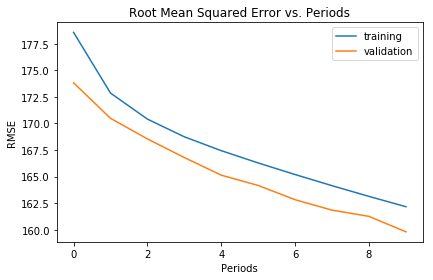

In [0]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    hidden_units=[10, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='intro_to_neural_nets')])

In [0]:
# Visualize loss and metrics using TensorBoard
%tensorboard --logdir intro_to_neural_nets

Reusing TensorBoard on port 6006 (pid 3311), started 0:19:54 ago. (Use '!kill 3311' to kill it.)

### Solution

Click below to see a possible solution

**NOTE:** This selection of parameters is somewhat arbitrary. Here we've tried combinations that are increasingly complex, combined with training for longer, until the error falls below our objective (training is nondeterministic, so results may fluctuate a bit each time you run the solution). This may not be the best combination; others may attain an even lower RMSE. If your aim is to find the model that can attain the best error, then you'll want to use a more rigorous process, like a parameter search.

Train on 200 samples, validate on 5000 samples
200/200 [==============================] - 1s 6ms/step - loss: 254.6282 - mse: 113811.1016 - val_loss: 172.5630 - val_mse: 30213.0332
period 00 is finished
Train on 200 samples, validate on 5000 samples
200/200 [==============================] - 1s 5ms/step - loss: 168.5799 - mse: 28420.4531 - val_loss: 168.5182 - val_mse: 28835.1641
period 01 is finished
Train on 200 samples, validate on 5000 samples
200/200 [==============================] - 1s 6ms/step - loss: 164.8319 - mse: 27170.7832 - val_loss: 164.5932 - val_mse: 27461.0879
period 02 is finished
Train on 200 samples, validate on 5000 samples
200/200 [==============================] - 1s 7ms/step - loss: 160.3793 - mse: 25723.7402 - val_loss: 159.4640 - val_mse: 25736.7695
period 03 is finished
Train on 200 samples, validate on 5000 samples
200/200 [==============================] - 1s 6ms/step - loss: 154.2794 - mse: 23806.2344 - val_loss: 152.6020 - val_mse: 23536.8086
period 04 i

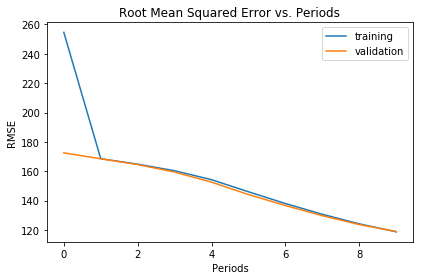

In [0]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='intro_to_neural_nets')])

## Task 2: Evaluate on Test Data

**Confirm that your validation performance results hold up on test data.**

Once you have a model you're happy with, evaluate it on test data to compare that to validation performance.

Reminder, the test data set is located [here](https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv).

In [0]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

# YOUR CODE HERE

### Solution

Click below to see a possible solution.

Similar to what the code at the top does, we just need to call evaluate and get root_mean_squared_error.

Note that we don't have to randomize the test data, since we will use all records.

In [0]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

# Evaluate the model
test_rmse = dnn_regressor.evaluate(test_examples.values, test_targets.values)
print("Final RMSE (on test data): %0.2f" % test_rmse[0])

3000/3000 [==============================] - 0s 35us/sample - loss: 113.3877 - mse: 13182.1865
Final RMSE (on test data): 113.39
